# Generate a completely randomized gene expression dataset

Tong Shu Li

**Motive**: We would like to confirm that a completely randomized dataset does not display the drift property that we observe in PMID26623667. To this end, we will create a dataset from scratch and use it to confirm that there is no drift.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from itertools import product

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density

In [4]:
np.random.seed(20160615)

In [5]:
%matplotlib inline

---

## Reference gene expression distribution

We will model our hypothetical RNA-seq log CPM distribution as a Gaussian distribution with 3.5 mean, 1.5 standard deviation. This looks roughly like the log CPM distribution observed for PMID26623667.

In [6]:
exp_mean = 3.5
exp_std = 1.5

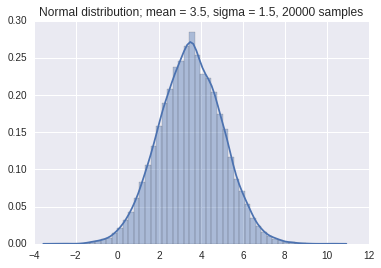

In [7]:
n = 20000
res = np.random.normal(loc = exp_mean, scale = exp_std, size = n)

ax = sns.distplot(res)
ax.set_title(
    "Normal distribution; mean = {}, sigma = {}, {} samples".format(exp_mean, exp_std, n)
);

This distribution roughly looks like the RNA-seq log CPM distribution of PMID26623667. Note that the real distribution has more variation, and has a longer tail on the right. However this is close enough to the real distribution for our purposes.

## Generate random distributions

Now that we have a distribution which we will use to model the gene expression data, let us generate the fake dataset.

### Parameter settings

Age: 1, 3, 5, 7, and 10 days old. Treatments: control and drug. Five replicates for each condition, and 20000 genes per sample.

In [8]:
days = [1, 3, 5, 7, 10]
conditions = ["control", "drug"]

num_genes = 20000
replicates = 5

genes = np.array(["gene_{}".format(i) for i in range(num_genes)])

### Generate the expression values

In [9]:
res = []
for day, condition, replicate in product(days, conditions, range(replicates)):
    gene_order = np.random.permutation(genes)
    
    # log expression values
    exp_vals = np.random.normal(loc = exp_mean, scale = exp_std, size = num_genes)
    
    res.append(pd
        .DataFrame({"gene_id": gene_order, "log_cpm": exp_vals})
        .assign(age = day, condition = condition, replicate = replicate)
    )

### Examine results

In [10]:
exp = (pd
    .concat(res)
    .assign(cpm = lambda df: np.exp(df["log_cpm"]))
    .sort_values(["age", "condition", "replicate", "gene_id"])
    .reset_index(drop = True)
)

In [11]:
exp.shape

(1000000, 6)

In [12]:
exp.head()

,gene_id,log_cpm,age,condition,replicate,cpm
0,gene_0,5.707996,1,control,0,301.266626
1,gene_1,2.018717,1,control,0,7.528661
2,gene_10,1.520157,1,control,0,4.572941
3,gene_100,2.886037,1,control,0,17.922135
4,gene_1000,3.978630,1,control,0,53.443782


In [13]:
exp["gene_id"].nunique()

20000

### Expression distribution

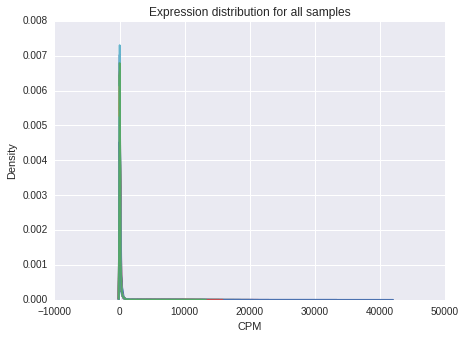

In [14]:
ax = plot_multi_density(
    exp, ["age", "condition", "replicate"], "cpm",
    rc = {"figure.figsize": (7, 5)}
)

ax.legend_.remove()
ax.set_xlabel("CPM")
ax.set_title("Expression distribution for all samples");

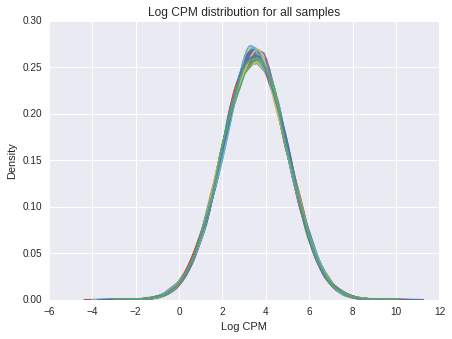

In [15]:
ax = plot_multi_density(
    exp, ["age", "condition", "replicate"], "log_cpm",
    rc = {"figure.figsize": (7, 5)}
)

ax.legend_.remove()
ax.set_xlabel("Log CPM")
ax.set_title("Log CPM distribution for all samples");

These plots look similar to the distributions we observed for PMID26623667.

---

## Calculate young reference

The young reference CPM value is the mean of all replicates for the control samples at day 1.

In [16]:
ref = (exp
    .query("age == 1 & condition == 'control'")
    .drop(["age", "replicate", "log_cpm"], axis = 1)
    .groupby("gene_id")
    .mean()
    .reset_index()
    .rename(columns = {"cpm": "ref_cpm"})
)

In [17]:
ref.shape

(20000, 2)

In [18]:
ref.head()

,gene_id,ref_cpm
0,gene_0,100.435414
1,gene_1,72.421402
2,gene_10,62.747363
3,gene_100,39.066082
4,gene_1000,235.874867


## Merge young reference into expression dataframe and calculate RLFEC

In [19]:
final = (exp
    .merge(ref, how = "inner", on = "gene_id")
    .assign(RLFEC = lambda df: np.log(df["cpm"] / df["ref_cpm"]))
)

In [20]:
final.shape

(1000000, 8)

In [21]:
final.head()

,gene_id,log_cpm,age,condition,replicate,cpm,ref_cpm,RLFEC
0,gene_0,5.707996,1,control,0,301.266626,100.435414,1.098481
1,gene_0,1.251806,1,control,1,3.496652,100.435414,-3.357709
2,gene_0,3.725502,1,control,2,41.492051,100.435414,-0.884013
3,gene_0,4.113772,1,control,3,61.177045,100.435414,-0.495743
4,gene_0,4.551186,1,control,4,94.744695,100.435414,-0.058329


## Save to file

In [22]:
final.to_csv("random_expset.tsv", sep = '\t', index = False)